# Part 2 - Tone Over Time and Sentiment Analysis

## Part 2: How has the tone of inaugural addresses changed over time?
Answered by these subquestions:
- Has there been more fearmongering or polarizing speech over time?
- Which president has the most polarizing speech?

## Packages

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from afinn import Afinn
import spacy

## Loading Data

In [38]:
from make_data import write_inaugural_addresses
write_inaugural_addresses(n_speeches=55)

In [39]:
data = pd.read_csv("data/inaugural_address.csv")
data = data.drop(data.columns[0], axis=1)
data["word count"] = data["text"].str.split().str.len()
data["character count"] = data["text"].str.len()
data["year"] = data["date"].str[:4]
data['date'] = pd.to_datetime(data['date'])

# fixing Trump's label in the dataset
data.iloc[52, 0] = "Donald J. Trump"
data.iloc[54, 0] = "Donald J. Trump"

In [40]:
# Showing first rows of data
data.head()

,president_name,president_number,date,text,word count,character count,year
0,George Washington,1,1789-04-30 00:00:00+00:00,\nFellow-Citizens of the Senate and of the Hou...,1430,8625,1789
1,George Washington,1,1793-03-04 00:00:00+00:00,\nFellow Citizens:\nI AM again called upon by ...,135,788,1793
2,John Adams,2,1797-03-04 00:00:00+00:00,"\nWHEN it was first perceived, in early times,...",2319,13864,1797
3,Thomas Jefferson,3,1801-03-04 00:00:00+00:00,\nFriends and Fellow-Citizens:\nCALLED upon to...,1717,10117,1801
4,Thomas Jefferson,3,1805-03-04 00:00:00+00:00,"\nPROCEEDING, fellow-citizens, to that qualifi...",2157,12892,1805


## Has there been more fearmongering or polarizing speech over time?

Here polarizing speech is defined with a lexicon of negative words and fearmongering is defined as 'us vs them' rhetoric. 

#### Polarizing speech over time:

In [41]:
afinn = Afinn()

data["sentiment_score"] = data["text"].apply(afinn.score)

# Normalize by speech length
data["sentiment_per_word"] = data["sentiment_score"] / data["word count"]

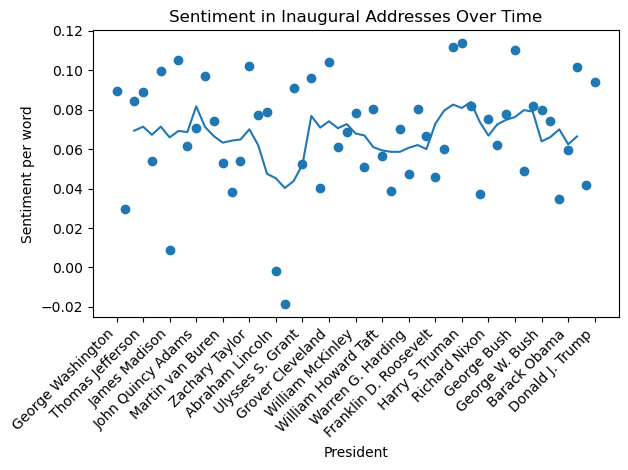

In [42]:
# Plotting overall sentiment over time
x = range(len(data))

plt.figure()
plt.scatter(x, data["sentiment_per_word"])
plt.plot(
    x,
    data["sentiment_per_word"].rolling(5, center=True).mean()
)

plt.xlabel("President")
plt.ylabel("Sentiment per word")
plt.title("Sentiment in Inaugural Addresses Over Time")

# showing only every 3rd president for the sake of space
plt.xticks(
    ticks=x[::3],
    labels=data["president_name"].iloc[::3],
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.show()

# Downward trend shows more negative or fear oriented language

Defining a concrete lexicon of polarizing words:

In [43]:
polarizing_words = {
    "fear", "danger", "threat", "enemy", "crisis", "violence",
    "terror", "war", "risk", "uncertainty", "destruction",
    "attack", "harm", "conflict"
}

In [44]:
def polarizing_word_rate(text):
    words = text.lower().split()
    return sum(word in polarizing_words for word in words) / len(words)

data["polarizing_rate"] = data["text"].apply(polarizing_word_rate)

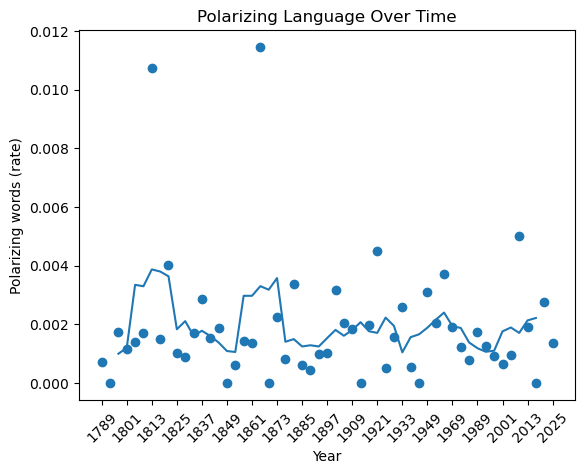

In [45]:
# Plotting fear language (polarization) over time

plt.figure()
plt.scatter(data["year"], data["polarizing_rate"])
plt.plot(
    data["year"],
    data["polarizing_rate"].rolling(5, center=True).mean()
)
plt.xlabel("Year")
plt.ylabel("Polarizing words (rate)")
plt.title("Polarizing Language Over Time")

# showing only every 3rd president for the sake of space
plt.xticks(x[::3],rotation=45)
plt.show()

#### Fearmongering:
This often shows up as ingroup vs outgroup framing, so we use 'us vs them' rhetoric to measure it.

In [46]:
ingroup = {"we", "us", "our", "ours"}
outgroup = {"they", "them", "their", "theirs"}

In [47]:
def fear_score(text):
    words = text.lower().split()
    in_count = sum(word in ingroup for word in words)
    out_count = sum(word in outgroup for word in words)
    return (in_count + out_count) / len(words)

data["fearmongering_rate"] = data["text"].apply(fear_score)

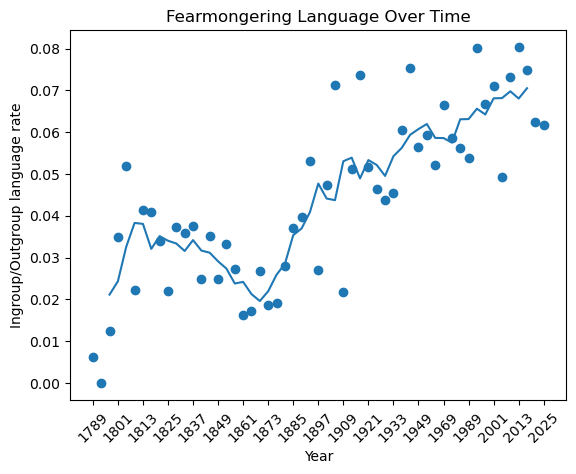

In [48]:
plt.figure()
plt.scatter(data["year"], data["fearmongering_rate"])
plt.plot(
    data["year"],
    data["fearmongering_rate"].rolling(5, center=True).mean()
)
plt.xlabel("Year")
plt.ylabel("Ingroup/Outgroup language rate")
plt.title("Fearmongering Language Over Time")
plt.xticks(x[::3], rotation=45)
plt.show()

It is clear from these graphs that, although inaugural speeches have not become significantly more negative in their sentiment over the centuries, there is an evident shift in fearmongering language. A distinct dip was shown in fearmongering ('us vs them' rhetoric) around Abraham Lincoln's presidency and the Civil War, but since then has steadily increased, with the highest levels being seen during Barack Obama's presidency. 

## Which president has the most polarizing speech and which has shown most fearmongering?
Since some presidents appear multiple times (having multiple inaugurals), we average by president:

In [51]:
# most polarizing speech (speeches with most negative sentiment)
top_polarizing_speeches = (
    data[["president_name", "year", "polarizing_rate"]]
    .sort_values("polarizing_rate", ascending=False)
)

second_most_polarizing_speech = top_polarizing_speeches.iloc[0]
second_most_polarizing_speech

president_name     Abraham Lincoln
year                          1865
polarizing_rate           0.011461
Name: 19, dtype: object

In [52]:
# 2nd most polarizing speech
top_polarizing_speeches = (
    data[["president_name", "year", "polarizing_rate"]]
    .sort_values("polarizing_rate", ascending=False)
)

second_most_polarizing_speech = top_polarizing_speeches.iloc[1]
second_most_polarizing_speech

president_name     James Madison
year                        1813
polarizing_rate         0.010744
Name: 6, dtype: object

In [53]:
# most fearmongering speech (speeches with most 'us vs them' rhetoric)

top_fearmongering_speeches = (
    data[["president_name", "year", "fearmongering_rate"]]
    .sort_values("fearmongering_rate", ascending=False)
)

most_fearmongering_speech = top_fearmongering_speeches.iloc[0]
most_fearmongering_speech

president_name        Barack Obama
year                          2013
fearmongering_rate        0.080383
Name: 51, dtype: object

In [59]:
# Second most fearmongering speech

second_most_fearmongering_speech = top_fearmongering_speeches.iloc[1]
second_most_fearmongering_speech

president_name        William J. Clinton
year                                1993
fearmongering_rate                0.0801
Name: 46, dtype: object

## Summary Table by Era:

In [61]:
data["year"] = data["year"].astype(int)

In [64]:
data["era"] = pd.cut(
    data["year"],
    bins=[1780, 1850, 1900, 1950, 2000, 2030],
    labels=["Early", "19th c.", "Early 20th", "Cold War", "Modern"]
)

data.groupby("era")[["sentiment_per_word", "fearmongering_rate", "polarizing_rate"]].mean()

,sentiment_per_word,fearmongering_rate,polarizing_rate
era,,,
Early,0.069509,0.028856,0.002055
19th c.,0.060688,0.028612,0.002028
Early 20th,0.068571,0.053702,0.001818
Cold War,0.071981,0.061706,0.001700
Modern,0.069526,0.067547,0.001810


By this table, we can see that the lowest sentiment per word has been observed in the 19th century, the most fearmongering language has occurred in this modern era we are in now, and the most polarizing speech was observed during the cold war, with the modern era seeing a slight increase from that.

Though sentiment analysis shows that negative sentiment in inaugural addresses has mostly stayed constant through the eras, a surprising result of this analysis is that fearmongering using 'us vs them' rhetoric has strongly increased. Presidents are increasingly acknowledging division and conflict in their rhetoric, reflecting a broader shift toward more polarized political discourse in the United States.